# Dota data

Script to get Dota data.

We use the OpenDota API <https://docs.opendota.com/>.

**For now only the last 10 games per heroes are requested.**

In [1]:
import requests
from pprint import pprint as pp
import pandas as pd

ACCOUNT_ID = 67066065
HERO_NAME = "Ogre Magi"
SLICE_SIZE = 10

## Get player data

<https://docs.opendota.com/#tag/players>

In [2]:
req = requests.get(f"https://api.opendota.com/api/players/{ACCOUNT_ID}")

pp(req.json())

{'competitive_rank': None,
 'leaderboard_rank': None,
 'mmr_estimate': {'estimate': 3326},
 'profile': {'account_id': 67066065,
             'avatar': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/ba/ba46611accb02df3a7a1ba5eaf461bdb10a4a3e0.jpg',
             'avatarfull': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/ba/ba46611accb02df3a7a1ba5eaf461bdb10a4a3e0_full.jpg',
             'avatarmedium': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/ba/ba46611accb02df3a7a1ba5eaf461bdb10a4a3e0_medium.jpg',
             'cheese': 0,
             'is_contributor': False,
             'last_login': '2017-10-21T17:34:56.898Z',
             'loccountrycode': None,
             'name': None,
             'personaname': 'Celebrated Pooper',
             'plus': False,
             'profileurl': 'https://steamcommunity.com/profiles/76561198027331793/',
             'steamid': '76561198027331793'},
 'rank_tier': 52,
 'solo_compe

### Get player matches

<https://docs.opendota.com/#tag/players%2Fpaths%2F~1players~1%7Baccount_id%7D~1matches%2Fget>

In [3]:
req = requests.get(f"https://api.opendota.com/api/players/{ACCOUNT_ID}/matches")

df_matches = pd.DataFrame(req.json())

### Get hero data

<https://docs.opendota.com/#tag/heroes%2Fpaths%2F~1heroes%2Fget>

`localized_name` contains the name.

In [4]:
req = requests.get(f"https://api.opendota.com/api/heroes")

df_heroes = pd.DataFrame(req.json())

HERO_ID = df_heroes[df_heroes["localized_name"].str.contains(HERO_NAME, case=False)].iloc[0]["id"]

pp(HERO_ID)

84


### Get Ogre matches

Get all matches played as `HERO_NAME`.

In [5]:
hero_matches_id_list = df_matches[df_matches["hero_id"] == HERO_ID]["match_id"].to_list()

hero_matches_list = [requests.get(f"https://api.opendota.com/api/matches/{match_id}").json() for match_id in hero_matches_id_list[:SLICE_SIZE]]

df_hero_matches = pd.DataFrame(hero_matches_list)

### Filter players by `ACCOUNT_ID`

Filter `HERO_NAME` matches by `ACCOUNT_ID`.

In [6]:
player_lists = df_hero_matches["players"].to_list()

account_hero_matches_list = [p for l in player_lists for p in l if p["account_id"] == ACCOUNT_ID]

df = pd.DataFrame(account_hero_matches_list)

### Get starting items

Get startings items per match.

starting_items  win
0  [tango, ring_of_protection, enchanted_mango, w...    0
1      [tango, sobi_mask, enchanted_mango, branches]    0
2  [tango, enchanted_mango, ring_of_protection, w...    0
3  [tango, enchanted_mango, enchanted_mango, ward...    1
4  [tango, quelling_blade, enchanted_mango, ward_...    1
5  [tango, enchanted_mango, enchanted_mango, ward...    0
6  [tango, enchanted_mango, enchanted_mango, ward...    0
7  [tango, enchanted_mango, enchanted_mango, ward...    1
8  [tango, enchanted_mango, enchanted_mango, ward...    0
9  [tango, enchanted_mango, enchanted_mango, ward...    1


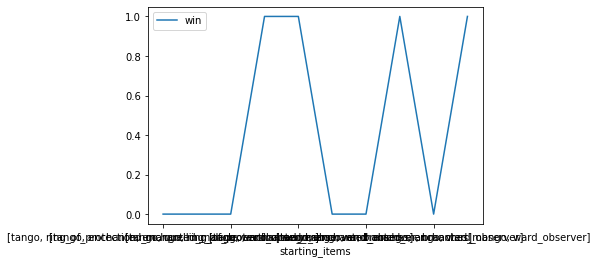

In [7]:
starting_items = [[i["key"] for i in item_list if i["time"]<0] for item_list in df["purchase_log"].to_list()]

df_clean = pd.DataFrame(
    {
        "starting_items": starting_items,
        "win": df["win"].to_list(),
    })

pp(df_clean)

df_clean.plot(x="starting_items", y="win")

import matplotlib.pyplot as plt

plt.show()

### Compute winrate per item

Number of matche and wins and the winrate are computed per item.


wins  num   winrate
ward_observer          4    9  0.444444
tango                  4   10  0.400000
quelling_blade         1    1  1.000000
enchanted_mango        4   10  0.400000
sobi_mask              0    1  0.000000
branches               1    3  0.333333
ring_of_protection     0    2  0.000000


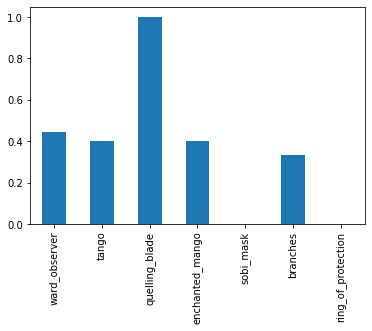

In [9]:
# generate a list with all starting items
# duplicates are removed
item_list = list(set([i for l in df_clean["starting_items"].tolist() for i in l]))

# filter if an item is contained in a  match entry
f = {i: [i in m for m in df_clean["starting_items"].tolist()] for i in item_list}

import numpy as np

# get number of matches per item
matches_per_item = {i: np.sum(f[i]) for i in item_list}
# get number of wins per item
wins_per_item = {i: df_clean["win"][f[i]].sum() for i in item_list}

df_winrate_per_item = pd.DataFrame({"wins": wins_per_item, "num": matches_per_item})

# compute winrate per item
df_winrate_per_item["winrate"] = df_winrate_per_item["wins"]/df_winrate_per_item["num"]
pp(df_winrate_per_item)

# plot winrate per item
df_winrate_per_item["winrate"].plot(kind="bar")
plt.show()